# Localizing Multiple Cells Using LodeSTAR

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch06_SelfSupervised/ec06_A_cell_localization/cell_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00

This notebook provides you with a complete code example that trains a convolutional neural network to detect cells using a single crop of a cell and, then, it evaluates the performance of the trained network on all the images available in the sequence.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 6-A from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Using the Cell Tracking Challenge Dataset

You’ll use a dataset from the Cell Tracking Challenge, which includes a series of videos of proliferating mouse hematopoietic stem cells. Even though
you don’t need ground truth positions to train the neural network, you can use the annotations provided for the challenge to evaluate the detection performance of your trained network.

Download the BF-C2DL-HSC dataset of the Cell Tracking Challenge ...

In [3]:
import deeptrack as dt
import numpy as np

optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm, NA=0.9, magnification=1,
    resolution=0.1 * dt.units.um, output_region=(0, 0, 50, 50),
)
particle = dt.PointParticle(position=(25, 25), intensity=1.2e4, z=0)
sim_im_pip = optics(particle) >> dt.Add(30) >> np.random.poisson >> dt.Add(82)

/usr/local/lib/python3.11/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [4]:
optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm, NA=0.9, magnification=1,
    resolution=0.1 * dt.units.um, output_region=(0, 0, 128, 128),
)
particle = dt.PointParticle(
    position=lambda: np.random.uniform(0, 128, size=2),
    intensity=lambda: np.random.uniform(6e3, 3e4),
    z=lambda: np.random.uniform(-1.5, 1.5) * dt.units.um,
)
postprocess = (dt.Add(lambda: np.random.uniform(20, 40)) >> np.random.poisson
               >> dt.Add(lambda: np.random.uniform(70, 90)))
normalization = dt.AsType("float") >> dt.Subtract(110) >> dt.Divide(250)
particles = particle ^ (lambda: np.random.randint(10, 20))
sim_im_pip = optics(particles) >> postprocess >> normalization

In [5]:
sim_mask_pip = (particles
                >> dt.SampleToMasks(lambda: lambda particle: particle > 0,
                                    output_region=optics.output_region,
                                    merge_method="or")
                >> dt.AsType("int") >> dt.OneHot(num_classes=2))

In [45]:
import torch

sim_im_mask_pip = ((sim_im_pip & sim_mask_pip) >> dt.MoveAxis(2, 0)
                   >> dt.pytorch.ToTensor(dtype=torch.float))

train_dataset_ev = dt.pytorch.Dataset(sim_im_mask_pip, length=400, replace=False)

torch.Size([1, 128, 128]) torch.Size([2, 128, 128])


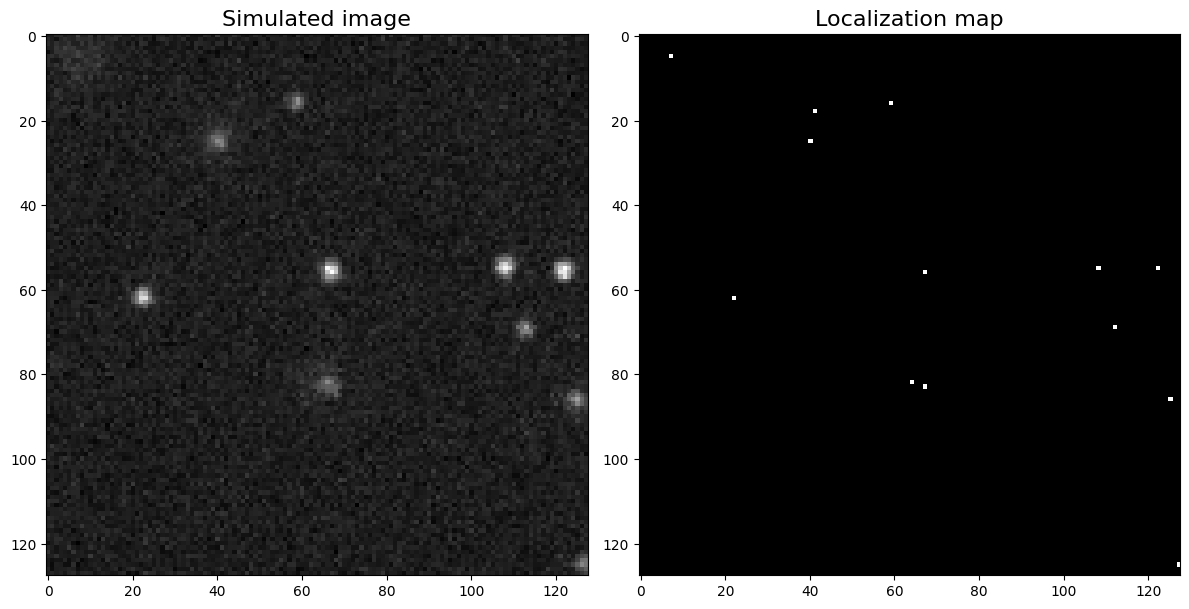

In [8]:
import matplotlib.pyplot as plt
sim_im, sim_mask = sim_im_mask_pip.update().resolve()
print(sim_im.shape, sim_mask.shape)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sim_im.squeeze(), cmap="gray")
plt.title("Simulated image", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(sim_mask[1], cmap="gray")
plt.title("Localization map", fontsize=16)

plt.tight_layout()
plt.show()

torch.Size([128, 128, 1])


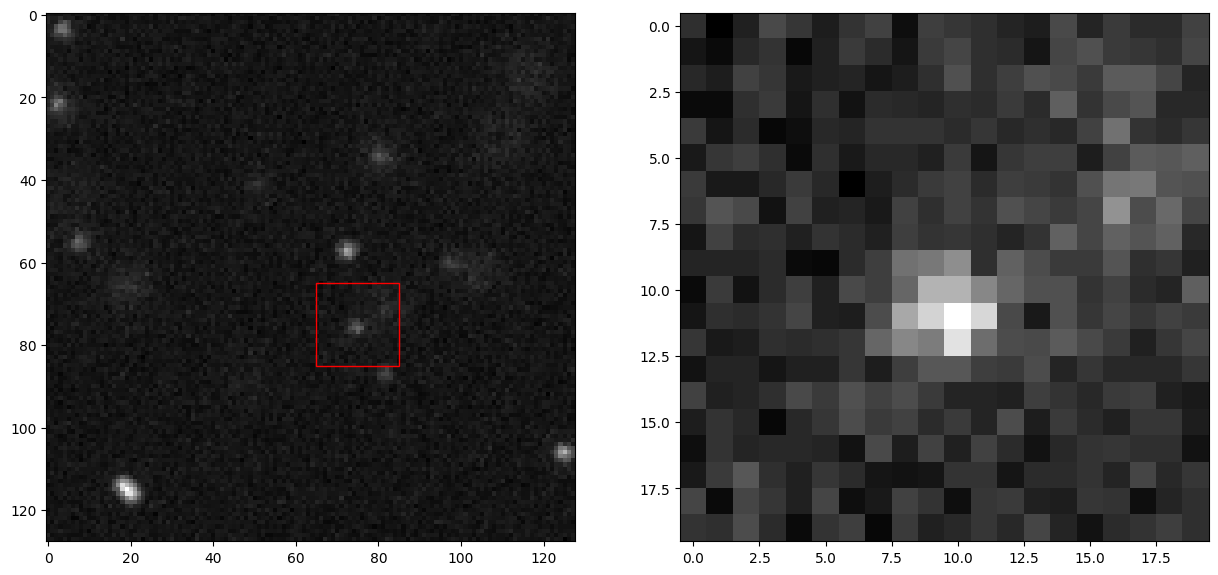

In [31]:
crop_size = 20
crop_x0, crop_y0 = 75 - crop_size // 2, 75 - crop_size // 2

image = sim_im.permute(1, 2, 0)
print(image.shape)
crop = image[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size]

from matplotlib.patches import Rectangle

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.gca().add_patch(Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                              linewidth=1, edgecolor="r", facecolor="none"))

plt.subplot(1, 2, 2)
plt.imshow(crop, cmap="gray")

plt.show()

... create the pipeline to load the images and the relative ground truth cell positions ...

... and plot some images with the cell ground truth positions.

In [9]:
!pip install imagecodecs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 52.0 MB/s eta 0:00:00


## Creating the Training Pipeline and Data Loader

Create the training pipeline ...

... and the dataset and data loader.

In [40]:
import numpy as np
import torch

train_pip = (dt.Value(crop.numpy)
             >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
             >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
             >> dt.MoveAxis(-1, 0) >> dt.pytorch.ToTensor(dtype=torch.float32))

print(crop.numpy().shape)

(20, 20, 1)


In [41]:
import deeplay as dl

train_dataset = dt.pytorch.Dataset(train_pip, length=400, replace=False)
dataloader = dl.DataLoader(train_dataset, batch_size=8, shuffle=True)


## Training the Neural Network

Define and train the LodeSTAR neural network ...

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build().to(device)

trainer = dl.Trainer(max_epochs=200)
trainer.fit(lodestar, dataloader)


INFO: 
  | Name          | Type                       | Params | Mode 
---------------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K  | train
1 | between_loss  | L1Loss                     | 0      | train
2 | within_loss   | L1Loss                     | 0      | train
3 | train_metrics | MetricCollection           | 0      | train
4 | val_metrics   | MetricCollection           | 0      | train
5 | test_metrics  | MetricCollection           | 0      | train
6 | optimizer     | Adam                       | 0      | train
---------------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                       | Params | Mode 
------------------------------------

Using device: cuda


Training: |          | 0/? [00:00<?, ?it/s]

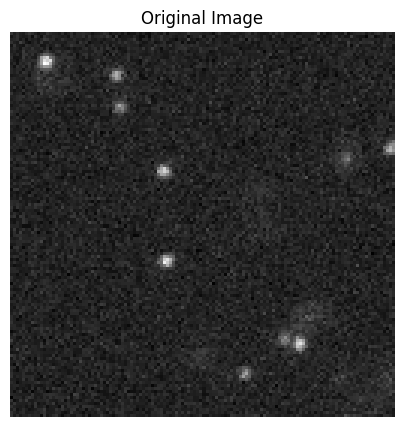

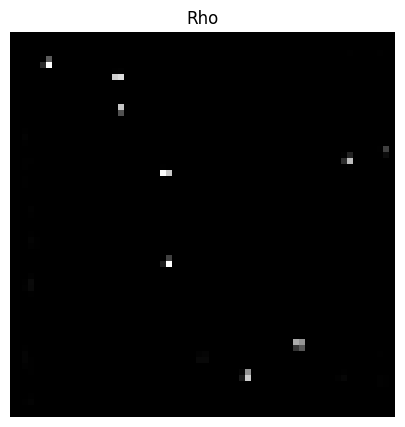

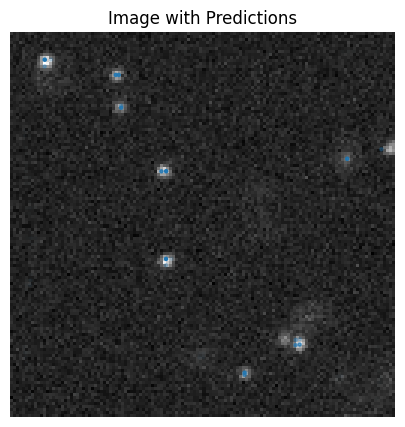

In [93]:
image_index = 300
image, mask = train_dataset_ev[image_index]


lodestar = lodestar.to("cuda")

prediction = lodestar(image.unsqueeze(0).to("cuda"))
prediction = prediction.squeeze().cpu().detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]


plt.figure(figsize=(6, 5))
plt.imshow(image[0], cmap="gray")
plt.axis("off")
plt.title("Original Image")
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(rho, cmap="gray")
plt.axis("off")
plt.title("Rho")
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(image[0], cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")
# plt.xlim(0, 299)
# plt.ylim(0, 549)
plt.gca()
plt.title("Image with Predictions")
plt.show()



In [14]:
print(lodestar)

LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L1Loss()
  (within_loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.0001, params=

... and plot its predictions.

## Evaluating the Performance of the Trained Network

Fix the parameters to determine the positions of the cells in the images ...

In [114]:
alpha = 0.1
beta = 1 - alpha
cutoff = 0.2
mode = "constant"

... determine and plot the positions of the cells in the images ...

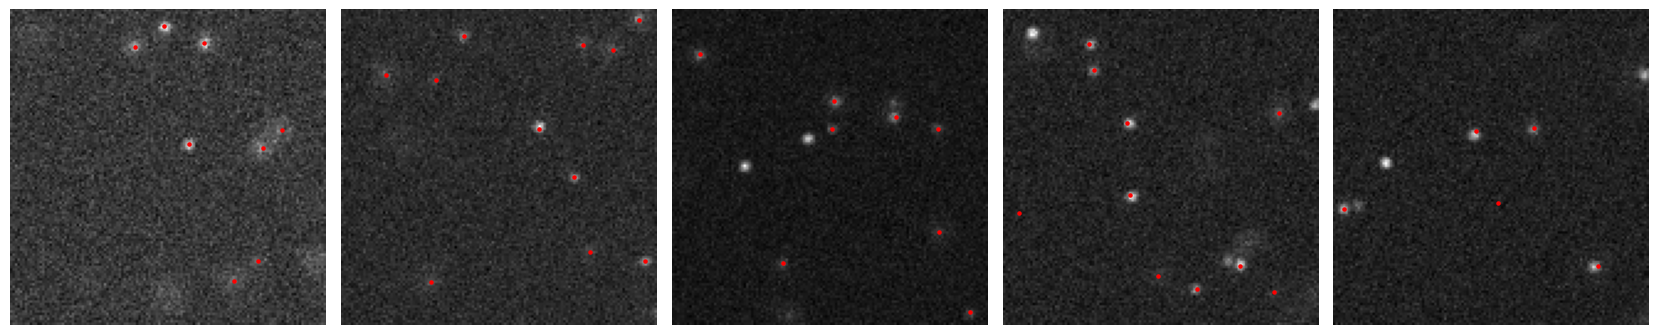

In [115]:
plt.figure(figsize=(20, 10))
for plot_idx, frame_idx in enumerate([0, 100, 200, 300, 350]):
    image, mask = train_dataset_ev[frame_idx]

    image_np = image.numpy().transpose(1, 2, 0)

    torch_image = torch.from_numpy(image_np).permute(2, 0, 1).unsqueeze(0).float()

    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                 mode="constant", cutoff=cutoff)[0]

    plt.subplot(1, 6, plot_idx + 1)
    plt.imshow(image_np.squeeze(), cmap="gray")
    if detections.size > 0:
        plt.scatter(detections[:, 1], detections[:, 0], s=5, color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()



... and calculate the F1-score to quantify the neural network performance.

In [116]:
import numpy as np
import scipy.optimize
import scipy.spatial

distance_th = 10

TP, FP, FN = 0, 0, 0
for image, mask in train_dataset_ev:
    detections = lodestar.detect(image.unsqueeze(0), alpha=alpha, beta=beta,
                                 mode="constant", cutoff=cutoff)[0]
    y_coords, x_coords = np.where(mask[1] == 1)

    centroids = np.column_stack((y_coords, x_coords))

    distance_matrix = scipy.spatial.distance_matrix(detections, centroids)
    row_idx, col_idx = scipy.optimize.linear_sum_assignment(distance_matrix)

    filtered_row_ind = row_idx[distance_matrix[row_idx, col_idx] < distance_th]
    filtered_col_ind = col_idx[distance_matrix[row_idx, col_idx] < distance_th]

    TP += len(filtered_row_ind)
    FP += len(detections) - len(filtered_row_ind)
    FN += len(centroids) - len(filtered_col_ind)


F1 = 2 * TP / (2 * TP + FP + FN)

print(f"TP: {TP} FP: {FP} FN:{FN} F1: {F1}")

TP: 3459 FP: 49 FN:2318 F1: 0.7450726978998384
